## Google ColabでscRNA-seq解析

Google ColabはGoogleが提供するクラウドサービスで、対応しているのはPythonのみですが、無料でGPUを使うことができるのが魅力です。お手軽に深層学習を試してみたい場合には重宝します。
実行した設定は保存されないため、毎回ライブラリをインストールする必要がありますが、一般的なデータ解析ライブラリ群（行列演算や機械学習など）は既にインストールされているので、インストールの手間はそれほどないでしょう。

（2021/4/30追記：現在はRにも対応しています。 [Google ColaboratoryでR言語を使う](https://htsuda.net/stats/colab.html)）

Python，Google Colaboratoryについては様々な参考資料や解説サイトがあります．例えば，以下のような資料も参考にしてください．

* [Python学習サイト集](https://qiita.com/kita33/items/8891c7c04b664e7669bf)
* [ゼロからはじめるPython第26回 (Colaboratorの使い方について）](https://news.mynavi.jp/article/zeropython-26/)
* [Google colaboratory FAQ](https://research.google.com/colaboratory/faq.html)

ここではPythonとGoogle Colabに慣れるため、データ読み込みと正規化、次元削減までを一般的なライブラリのみを用いて実行してみましょう。

**参考: Jupyter と Google Colab との違い**

   HTMLブラウザ上で逐次的にコマンドを実行していくこれらのサービスがJupyter notebook (JupyterLab) です。Jupyter上で行う作業は自分のPC上で行うことになり、解析環境は自分のPCのマシンスペックに依存します。また、Dockerから起動することで、今回のシングルセルツール導入済み環境など、自由な解析環境を作ることができます。

   Google Colab は Google社によって提供されている特殊なJupyter環境であり、Google クラウドにアクセスしている状態になります。そのため解析環境は手元のPCに依存しませんし、GPUを利用することも可能です。一方、Dockerなどを利用することはできず、Googleから提供されている環境のみ利用可能です。そのため環境にインストールされていないライブラリは毎回インストールし直す必要があり、大規模な解析環境構築には不向きです。

### 推奨ブラウザ環境
Google Colaboratory は主要なブラウザはサポートしています．特にChromeとFirefoxでは完全に動作するよう検証されています．


以降の作業は全てGoogle Colab上で行います。

### データ読み込み
wgetを使ってサンプルデータをダウンロードします。データサイズは10MBです。 
これはPBMCの10種類の細胞を各500細胞ずつ使った5,000細胞のラベルありデータです。コンマで区切られたテキストファイル（csv形式）です。


In [1]:
# ライブラリ読み込み（下記のライブラリは全てGoogle Colabにインストール済です）
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
# csvファイルをwgetでダウンロード
!wget http://nakatolab.iqb.u-tokyo.ac.jp/supplement/PBMC_10cell_types_total_500.csv.gz

--2021-04-30 12:22:13--  http://nakatolab.iqb.u-tokyo.ac.jp/supplement/PBMC_10cell_types_total_500.csv.gz
Resolving nakatolab.iqb.u-tokyo.ac.jp (nakatolab.iqb.u-tokyo.ac.jp)... 163.43.80.77
Connecting to nakatolab.iqb.u-tokyo.ac.jp (nakatolab.iqb.u-tokyo.ac.jp)|163.43.80.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5434256 (5.2M) [application/x-gzip]
Saving to: ‘PBMC_10cell_types_total_500.csv.gz.1’

PBMC_10cell_types_t 100%[===================>]   5.18M  1.68MB/s    in 3.1s    

2021-04-30 12:22:17 (1.68 MB/s) - ‘PBMC_10cell_types_total_500.csv.gz.1’ saved [5434256/5434256]



In [3]:
input_data = pd.read_csv("PBMC_10cell_types_total_500.csv.gz", index_col=0)
input_data.shape

(32738, 5000)

In [4]:
input_data.head()

,ACAGTCGAGTTACG-1,CACAATCTAAGGGC-1,TATACCACGCTATG-1,GTGTAGTGTCTATC-1,TGCTATACGTATCG-1,GCAGGCACTGCACA-1,AGCGGCTGACAGTC-1,CGAAGTACACTAGC-1,TAACATGACCTCGT-1,AACCGCCTCGAGAG-1,TACGGCCTCACAAC-1,GGCACGTGGCGGAA-1,ACCGTGCTAGCGTT-1,AGAAACGAACGTTG-1,GCGGGACTTGCTTT-1,AACGTGTGAGCGGA-1,CGTGTAGAAACAGA-1,AAGGTCTGATTCGG-1,AGAGTGCTGCGTTA-1,GTTCATACCCCTCA-1,TATCTTCTCCTTAT-1,GAGCGCTGGGAGGT-1,CAGATGACAAGAAC-1,AGAGGTCTTGCCAA-1,ATGCCGCTACGTTG-1,ATGCCGCTCCTCAC-1,CGGGACTGCGTTGA-1,CACCACTGCATCAG-1,TAGTGGTGTGGATC-1,GTTATGCTCCGTTC-1,TATGGTCTTGCTGA-1,GTGACCCTGTTCAG-1,TTGAATGAAGGGTG-1,TCCATAACTATTCC-1,GTCGACCTTTTCAC-1,CTAACACTAGTACC-1,CAGGAACTCTCATT-1,CTTTAGTGTTTCGT-1,ATCAACCTGTCTTT-1,TATTGCTGCTAGCA-1,...,ATCGGAACGGGAGT-1,AGACTTCTCTAGAC-1,TGCACGCTACCAGT-1,TGGTTACTACTCAG-1,CACGAAACGTACAC-1,CCTATTGAGATAGA-1,CCAGTCTGCCCTTG-1,AACGTTCTATGCTG-1,ACCCAAGACAGAGG-1,GGAAGGACCTTAGG-1,CAGAGGGACTACGA-1,TGATACCTCAGAGG-1,GCGATATGAATCGC-1,TAGAGCACTGGTTG-1,TACCATTGGAATCC-1,ACGAGGGATCGTAG-1,CTGAAGACCGATAC-1,CAAGGACTACTTTC-1,GTAGCATGGAATGA-1,CGCAGGTGATTTCC-1,GCGGCAACACCTGA-1,TAGGCATGGACGAG-1,TATGGGTGCAGAGG-1,TGTCTAACCTGTCC-1,AGTGTGACAAGCCT-1,ACGGCGTGTGACCA-1,ACACCCTGCGAACT-1,ACACATCTTGGTTG-1,GACTTTACCTGCTC-1,AAACTTGAGCCTTC-1,GAGTAAGACTAGTG-1,ACCTGGCTATTCGG-1,GTGAGGGAAAAGTG-1,CTCTAATGTGGGAG-1,GAGCAGGATCAGGT-1,AATCTCTGAAGAAC-1,ACGACCCTGCAGAG-1,TATGGTCTCAAAGA-1,TCTTGATGATCACG-1,ACTGAGACTTCACT-1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 細胞のアノテーション
細胞IDはバーコードで表されています。これを細胞名に変更します。（これは細胞名が既知である場合のみ可能です）

In [5]:
ncells = 500
cellname = ["regulatory_t", "cd56_nk", "naive_cytotoxic", "cytotoxic_t", "b_cell", 
            "memory_t", "naive_t", "cd4_helper_t", "cd14_monocytes", "cd34"]
labels= []
for cell in cellname:
    labels += [cell] * ncells

input_data.columns = labels
input_data.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### フィルタリング・正規化

In [6]:
## 全細胞で発現量0の遺伝子を除外
df = input_data
print("number of all genes: ", df.shape[0])

zero = np.all(df == 0, axis=1)
nonzero = np.logical_not(zero)
df = df[nonzero]
print("number of nonzero genes: ", df.shape[0])

number of all genes:  32738
number of nonzero genes:  16960


In [7]:
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 発現量のTotal read正規化・対数化
colsum = df.sum()
df = df / colsum * 10000
df = np.log1p(df)
df.head()

,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,regulatory_t,...,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34,cd34
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.047388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 次元削減
%%time はセルの実行時間を計測するためのマジックコマンドです。

In [9]:
%%time
A = df.T
pca = PCA()
pca.fit(A)
PC = pca.transform(A)

CPU times: user 7min 23s, sys: 14.1 s, total: 7min 37s
Wall time: 3min 55s


In [10]:
df = pd.DataFrame({ 'PC1' : PC[:,0], 'PC2' : PC[:,1], 'cell' : labels})
df.head()

,PC1,PC2,cell
0,-1.491188,2.378841,regulatory_t
1,-1.394000,-5.895192,regulatory_t
2,-2.681231,-1.834112,regulatory_t
3,1.455147,0.239732,regulatory_t
4,-0.864700,-1.447870,regulatory_t


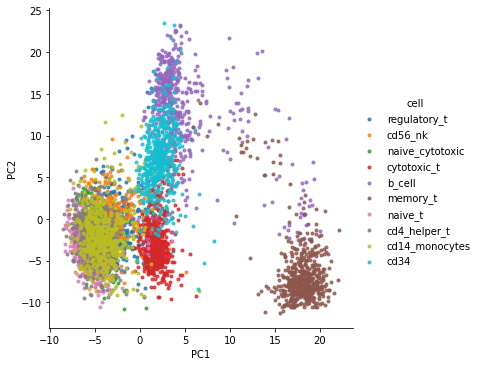

In [11]:
sns.lmplot(x="PC1", y="PC2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

In [12]:
%%time

# tSNEの計算
model = TSNE(n_components=2, perplexity=20, n_iter=5000, verbose=1, random_state=0)
tsne = model.fit_transform(PC[:,0:9])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.502542
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.670425
[t-SNE] KL divergence after 5000 iterations: 1.360592
CPU times: user 5min 29s, sys: 1.88 s, total: 5min 31s
Wall time: 2min 49s


In [14]:
df = pd.DataFrame({ 'tSNE_1' : tsne[:,0], 'tSNE_2' : tsne[:,1], 'cell' : labels})
df.head()

,tSNE_1,tSNE_2,cell
0,29.867262,-35.284283,regulatory_t
1,-6.607394,-20.787622,regulatory_t
2,21.704603,-10.506199,regulatory_t
3,28.161837,-41.953533,regulatory_t
4,24.546949,-39.936260,regulatory_t


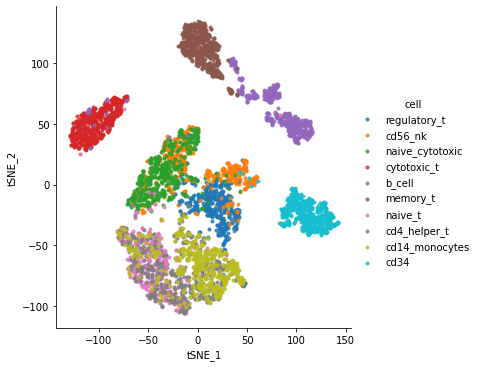

In [15]:
sns.lmplot(x="tSNE_1", y="tSNE_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

In [17]:
# UMAPの計算
# UMAPが入っていない場合は以下のコマンドでインストール
!pip install umap-learn

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 1.2MB 7.8MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=c09e08d6ed4eb7bc3b9c7820dd24fddafa346ae81016b8f38141d12de874e7dd
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=d985da65f48b7dfa7477edfea356573c168435e20c3e5bd503aa1e796bf6a0f0
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [18]:
import umap
um = umap.UMAP().fit_transform(PC[:,0:9])

In [19]:
df = pd.DataFrame({ 'UMAP_1' : um[:,0], 'UMAP_2' : um[:,1], 'cell' : labels})
df.head()

,UMAP_1,UMAP_2,cell
0,1.409212,-2.458809,regulatory_t
1,-0.491749,-1.008856,regulatory_t
2,0.097904,-2.531204,regulatory_t
3,1.619742,-2.151538,regulatory_t
4,1.497223,-2.088444,regulatory_t


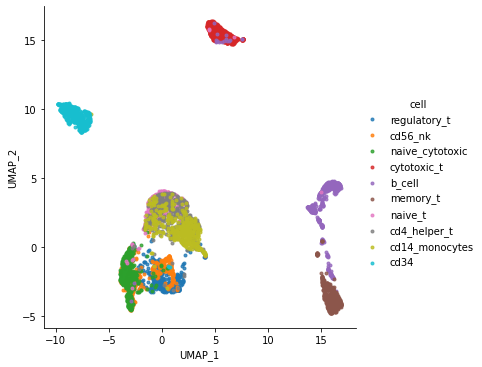

In [20]:
sns.lmplot(x="UMAP_1", y="UMAP_2", data=df, hue="cell", fit_reg=False, legend=True, markers=".")
plt.show()

### まとめ

PCA, tSNE, UMAP程度であれば特別な1細胞解析用ツールを使わずともこのように簡単に計算・図示できます。
一方、フィルタリングや正規化などは独自のプロトコルが採用されていることが多いので、そういった点に関しては専用のツールを使う方がよいでしょう。

In [22]:
!pip install sinfo

     |████████████████████████████████| 71kB 3.6MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp37-none-any.whl size=7012 sha256=5f74562827813a1ef0cd449ad4e331b1b3c8f550bbb2c1bbaf203e0897dc5c20
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo


In [23]:
from sinfo import sinfo
sinfo()

-----
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5
seaborn     0.11.1
sinfo       0.3.1
sklearn     0.22.2.post1
umap        0.5.1
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.7.1
notebook            5.3.1
-----
Python 3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2021-04-30 12:49
